# This is a Man's word

Mouting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nltk

First, we import all the libraries used for the project. 

In [ ]:
import pandas as pd
import bz2
import json
import string
import re
import matplotlib.pyplot as plt
import requests
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from collections import defaultdict
from functools import partial


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We then load Quotebank data, metadata and labels descriptions about the speakers. 


In [ ]:
path_to_2020_file = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 
get_path_to_file = lambda year: f'/content/drive/MyDrive/Quotebank/quotes-{year}.json.bz2' 

In [ ]:
speaker_attrs = pd.read_parquet("drive/MyDrive/Project datasets/speaker_attributes.parquet")

In [ ]:
attrs_labels = pd.read_csv('drive/MyDrive/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [ ]:
attrs_labels.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


The functions below were written by us before receiving the additional dataset containing label and description for QIDs. Right now this code is obsolete, but we leave it for a reference. Our approach was to query WikiData API for all of the occuring Q-codes, and interpolated the Q-codes with fetched labels.

In [ ]:
def query_wikidata_label(Q):
  """Resolve what is the label of a given Q-code."""
  get_uri = lambda q: f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={q}&languages=en&format=json"

  data = requests.get(get_uri(Q)).json()
  try:
    return data['entities'][Q]['labels']['en']['value']
  except KeyError:
    return ''


def extract_q_codes_labels(s, count = 200):
  """ Extracts country labels for most common countries."""
  countries_codes = list(set(s.explode()))
  common_countries_codes = [x for x, _ in Counter(countries_codes).most_common(count)]

  countries_labels = {}

  for code in common_countries_codes:
    try:
      countries_labels[code] = query_wikidata_label(code)
    except:
      print(f'Error, could not resolve code {code}')
  return countries_labels


def interpolate_q_codes_labels(s):
  """Given a series s with Q-codes, fetches representation of a Q-code (label)
  from wikidata and interpolates the values."""
  labels = extract_q_codes_labels(s)
  return s.apply(lambda codes: [labels.get(code, '') for code in codes] if codes is not None else None)


def resolve_q_codes(df, columns):
  """Interpolates q-codes in dataframe for specified columns."""
  for col in columns:
    df[col] = interpolate_q_codes_labels(df[col])

In [ ]:
# if more columns with q-codes need to be resolved they should be added here
Q_CODES_COLUMNS = ['nationality', 'occupation', 'gender']

And here is the actually used interface after receiving the speakers attribute data.


In [ ]:
def resolve_q_code(labels, q):
  '''Returns label of the QCODE if found.'''
  try:
    return labels.loc[q]['Label']
  except KeyError:
    return None


def interpolate_q_codes_new_way(df, labels, columns):
  '''Adds labeled features to the df.'''
  discard_none = lambda xs: filter(lambda x: x is not None, xs)
  for col in columns:
    df[col] = df[col].apply(lambda codes: list(discard_none(map(partial(resolve_q_code, labels), codes))) if codes is not None else None)

In [ ]:
# For the sake of the demo and fast performance we only take a subset,
# later on we will not restrict ourselves in such a way
speaker_attrs = speaker_attrs[:100_000]

In [ ]:
interpolate_q_codes_new_way(speaker_attrs, attrs_labels, Q_CODES_COLUMNS)

In [ ]:
speaker_attrs.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,None,W000178,"[politician, military officer, farmer, cartogr...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[Q7994501],None,"[playwright, screenwriter, novelist, children'...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,None,None,"[writer, lawyer, librarian, information scient...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,None,None,"[politician, motivational speaker, autobiograp...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,None,None,[painter],None,None,Q297,Diego Velázquez,None,item,None


In [ ]:
def construct_speaker_names(speaker_attrs):
  """Associates the speaker attributes index with all speaker aliases"""
  
  speaker_names = speaker_attrs.aliases.explode().append(speaker_attrs.label)
  speaker_names = speaker_names.drop(speaker_names[speaker_names.isna()].index)

  speaker_names_df = pd.DataFrame({"speaker": speaker_names, "speaker_attr_idx": speaker_names.index})
  speaker_names_df = speaker_names_df.set_index('speaker')
  return speaker_names_df

In [ ]:
speaker_names_df = construct_speaker_names(speaker_attrs)
speaker_names_df.head()

,speaker_attr_idx
speaker,
Washington,0
President Washington,0
G. Washington,0
Father of the United States,0
The American Fabius,0


We download now the Human Development Index dataset (HDI). The first nationality mentioned in the dataset for a given speaker is the one that we will match with the corresponding HDI score. HDI is represented as a number from 0 to 1, but we narrow down ourselves to four categories of developemnt: Very High, High, Medium, Low with ranges defined by United Nations.

In [ ]:
HDI = pd.read_excel('/content/drive/MyDrive/HDI_list.xlsx')
HDI.head()

,HDI rank,N,Development
0,1,Norway,Very High
1,2,Ireland,Very High
2,2,Switzerland,Very High
3,4,"Hong Kong, China (SAR)",Very High
4,4,Iceland,Very High


In [ ]:
def merge_HDI_with_chunk(chunk_df):
  '''Merges HDI score with speaker's first nationality'''

  chunk_df['N'] = [next(iter(nationality), ' ') for nationality in chunk_df['nationality']]
  chunk_df = pd.merge(chunk_df, HDI, on='N') 
  return chunk_df


def merge_speaker_attrs_with_chunk(chunk_df):
  '''Merges speakers attributes data based on speaker column'''
  
  chunk_df = chunk_df.join(speaker_names_df, on='speaker')
  # discard quotes for which the speaker could not be found
  chunk_df = chunk_df.drop(chunk_df[chunk_df.speaker_attr_idx.isna()].index)
  return chunk_df.join(speaker_attrs, on='speaker_attr_idx')

The next step is the data cleaning: we discard from the dataset those quotes with missing attributed speaker, gender, nationality or occupation. 


In [ ]:
def discard_na(df, col):
  '''Drops rows with col value equal to None.'''
  df[col].replace('None', pd.NA, inplace=True)
  df.drop(df[df[col].isna() == True].index, inplace=True)

def clean_speaker(chunk_df):
  discard_na(chunk_df, 'speaker')
  return chunk_df

def clean_gender(chunk_df):
  '''Drops rows with missing gender.'''
  discard_na(chunk_df, 'gender')
  return chunk_df

def clean_occupation(chunk_df):
  '''Drops rows with missing occupation.'''
  discard_na(chunk_df, 'occupation')
  return chunk_df

def clean_nationality(chunk_df):
  '''Drops rows with missing nationality.'''
  discard_na(chunk_df, 'nationality')
  return chunk_df

Now we take care of the content of the quotes: the quotes of a chunk are cleaned and tokenized to obtain single words. All of these, excluding the stopwords, are lemmatized and saved as keywords. Lemmatization consists of grouping together the inflected forms of a word so that they can be analyzed as a single item.


In [ ]:
ps = PorterStemmer()
lem = WordNetLemmatizer()


def normalize_quote(s:str) -> str:
    """Lower text and remove punctuation and extra whitespace."""
    
    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_punc(lower(s)))


def extract_keywords(text):
  """The text is tokenized, stop words are excluded and the 
     remaining ones are lemmatized and collected."""

  stopwords = nltk.corpus.stopwords.words('english')
  allWords = nltk.tokenize.word_tokenize(text)

  allWords = [lem.lemmatize(word) for word in allWords if word not in stopwords]
  return allWords

Then, we are interested in calculating the frequency of appearance of the keywords extracted from a chunk, and of the speakers' nationalities and occupations. 

In [ ]:
def frequency_distribution(chunk_df):
  '''Calculates frequency of keywords.'''

  combined_quotations = " ".join(entry for entry in chunk_df.quotation)
  keywords = extract_keywords(normalize_quote(combined_quotations))
  fd = nltk.FreqDist(keywords)
  return fd


def countries_distribution(chunk_df):
  '''Calculates frequencies of nationalities countries.'''
  countries = list(chunk_df.nationality.explode())
  return Counter(countries)


def occupations_distrubtion(chunk_df):
  '''Calculates frequencies of occupations.'''
  occupations = list(chunk_df.occupation.explode())
  return Counter(occupations)

All the previous preprocessing and cleaning operations are called into the following function to process each chunk.


In [ ]:
def process_chunk(chunk_df, aggregation):
  '''Applies basic preprocessing to a chunk: remove rows with missing 
     speakers. Merge the chunk with the speaker attributes and HDI indexes. Remove 
     rows with missing nationalities, genders and occupations. Calculates the features' distributions.'''

  chunk_df = clean_speaker(chunk_df)
  chunk_df = merge_speaker_attrs_with_chunk(chunk_df)
  chunk_df = clean_nationality(chunk_df)
  chunk_df = clean_gender(chunk_df)
  chunk_df = merge_HDI_with_chunk(chunk_df)

  chunk_df['g']=[g[0] for g in chunk_df['gender']]
  chunk_male_df = chunk_df.loc[chunk_df['g'] =='male']

  aggregation['words_frequency'] += frequency_distribution(chunk_df)
  aggregation['occupations_frequency'] += occupations_distrubtion(chunk_df)
  aggregation['countries_frequency'] += countries_distribution(chunk_df)

  # The same features are extracted for male speakers
  aggregation['words_male_frequency'] += frequency_distribution(chunk_male_df)
  aggregation['occupations_male_frequency'] += occupations_distrubtion(chunk_male_df)
  aggregation['countries_male_frequency'] += countries_distribution(chunk_male_df)
  return chunk_df

We extract a given number of chunks of specified size from the Quotebank file corresponding to a certain year. Then we process the chunk and calculate the distributions.

In [ ]:
def iterate_chunks(year, chunk_size, num_of_chunks):
  '''Extracts a number of chunks from the file corresponding to the specified year.'''

  with bz2.open(get_path_to_file(year), 'rb') as file:
    lines = []

    for i, line in enumerate(file):
      lines.append(json.loads(line))

      if i % chunk_size == 0 and i != 0:
        yield pd.DataFrame(lines)
        del lines[:]
        lines = []

        if i / chunk_size == num_of_chunks:
           return

    yield pd.DataFrame(lines)
    del lines[:]


def run_chunks_year(year, chunk_size = 10_000, num_of_chunks=3):
  '''Processes and calculates the features' distributions for each chunk.'''

  aggregation = defaultdict(Counter)

  for chunk_df in iterate_chunks(year, chunk_size, num_of_chunks):
      process_chunk(chunk_df, aggregation)
  return aggregation


def run_chunks_across_years(years, chunk_size = 10_000, num_of_chunks=3):
  '''Processes and calculates the features' distributions for each chunk for multiple years.'''

  return {year: run_chunks_year(year, chunk_size, num_of_chunks) for year in years}

In [ ]:
# As an example, we take a chunk and process it
chunk_df = next(iterate_chunks(2020, 10_000, 3))

In [ ]:
process_chunk(chunk_df, defaultdict(Counter)).head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,speaker_attr_idx,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,N,HDI rank,Development,g
0,2020-01-07-001821,a right-wing talking point.,Ricky Gervais,[Q23517],2020-01-07 00:00:00,1,"[[Ricky Gervais, 0.6196], [None, 0.2932], [Mar...",[http://www.neonnettle.com/news/9888-ricky-ger...,E,399.0,[Ricky Dene Gervais],[+1961-06-25T00:00:00Z],[United Kingdom],[male],1395460804,None,None,"[actor, writer, musician, comedian, screenwrit...",None,None,Q23517,Ricky Gervais,None,item,None,United Kingdom,13,Very High,male
1,2020-03-03-003454,"And I knew that wasn't the majority's opinion,...",Rachel Lindsay,"[Q3161936, Q39069563]",2020-03-03 00:45:48,1,"[[Rachel Lindsay, 0.8247], [None, 0.1156], [Pe...",[https://heavy.com/entertainment/2020/03/rache...,E,89356.0,"[Rachel Lindsay, Janey Scott, Rita Shulman Lew...",[+1926-12-22T00:00:00Z],"[United Kingdom, United Kingdom of Great Brita...",[female],1383280717,None,None,"[painter, writer, novelist, screenwriter, scie...",None,None,Q3161936,Roberta Leigh,None,item,None,United Kingdom,13,Very High,female
2,2020-01-18-025846,It's disappointing but there are 14 games left...,David Healy,"[Q1174698, Q313617, Q654415]",2020-01-18 18:56:48,1,"[[David Healy, 0.883], [None, 0.1082], [Andy M...",[https://www.belfasttelegraph.co.uk/sport/foot...,E,11756.0,[David Jonathan Healy],[+1979-08-05T00:00:00Z],[United Kingdom],[male],1395677945,None,None,"[association football player, association foot...",None,None,Q313617,David Healy,None,item,None,United Kingdom,13,Very High,male
3,2020-03-17-040168,just talking about it with you guys has kept u...,Idris Elba,[Q342604],2020-03-17 21:04:06,1,"[[Idris Elba, 0.5626], [None, 0.4374]]",[https://ew.com/celebrity/idris-elba-coronavir...,E,13191.0,"[Big Driis the Londoner, DJ Big Driis, Idrissa...",[+1972-09-06T00:00:00Z],"[United Kingdom, Sierra Leone]",[male],1393602893,None,None,"[actor, film producer, disc jockey, film actor...",None,None,Q342604,Idris Elba,None,item,None,United Kingdom,13,Very High,male
4,2020-03-19-049047,Oh my goodness. I loved these bath bombs. I re...,Katie Price,"[Q21466514, Q237602]",2020-03-19 12:46:37,1,"[[Katie Price, 0.5185], [None, 0.4815]]",[https://www.buzzfeed.com/malikabowling/walmar...,E,9257.0,"[Katrina Amy Alexandra Alexis Infield, Jordan,...",[+1978-05-22T00:00:00Z],[United Kingdom],[female],1334229361,None,None,"[actor, model, singer, autobiographer, novelis...",None,None,Q237602,Katie Price,None,item,None,United Kingdom,13,Very High,female


In [ ]:
agg_2020 = run_chunks_year(2020)

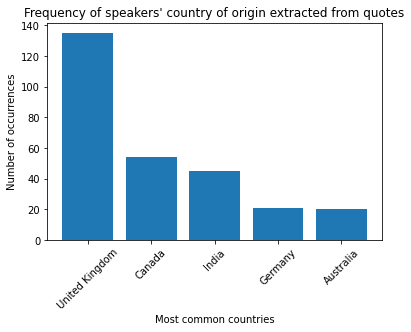

In [ ]:
#Let's visualize the most common features extracted from the quotes

plt.bar(*zip(*agg_2020['countries_frequency'].most_common(5)))
plt.xticks(rotation=45)
plt.xlabel("Most common countries")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' country of origin extracted from quotes")
plt.show()

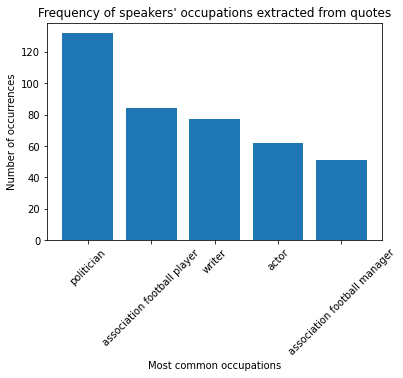

In [ ]:
plt.bar(*zip(*agg_2020['occupations_frequency'].most_common(5)))
plt.xlabel("Most common occupations")
plt.ylabel("Number of occurrences")
plt.title("Frequency of speakers' occupations extracted from quotes")
plt.xticks(rotation=45)
plt.show()

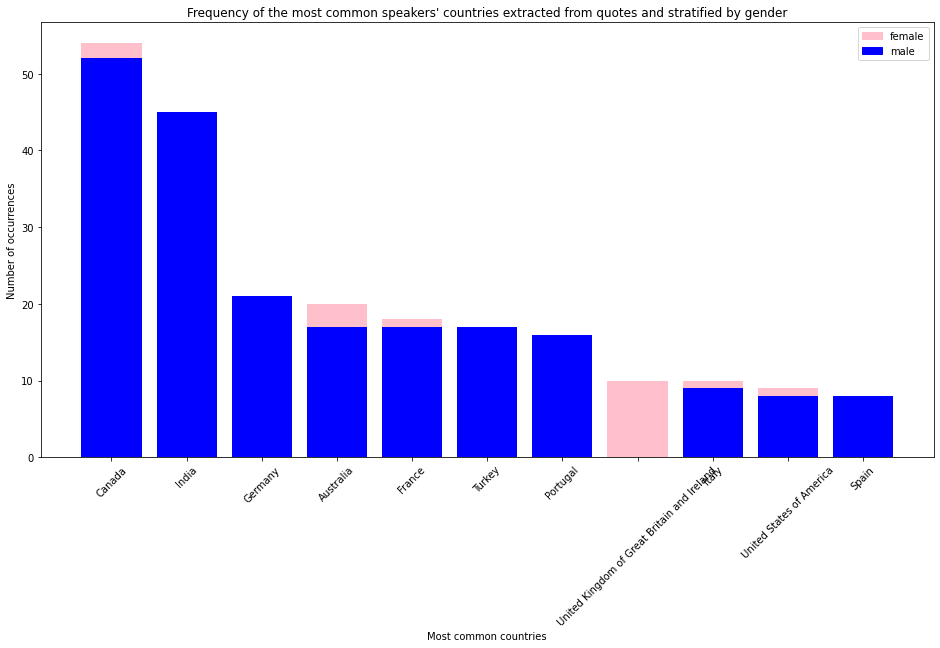

In [ ]:
# Here we would like to observe the same thing as above but stratified by gender

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def viewbar(feature, n=10):
  plt.figure(figsize=(16,8))
  plt.bar(*zip(*agg_2020[feature+'_frequency'].most_common(n+1)[1:]),color='pink')
  plt.bar(*zip(*agg_2020[feature+'_male_frequency'].most_common(n+1)[1:]),color='blue')
  plt.xlabel(f"Most common {feature}")
  plt.ylabel("Number of occurrences")
  plt.title(f"Frequency of the most common speakers' {feature} extracted from quotes and stratified by gender")
  plt.xticks(rotation=45)

  plt.legend(handles=[mpatches.Patch(color='pink', label='female'),mpatches.Patch(color='blue', label='male')])
  plt.show()

viewbar('countries')

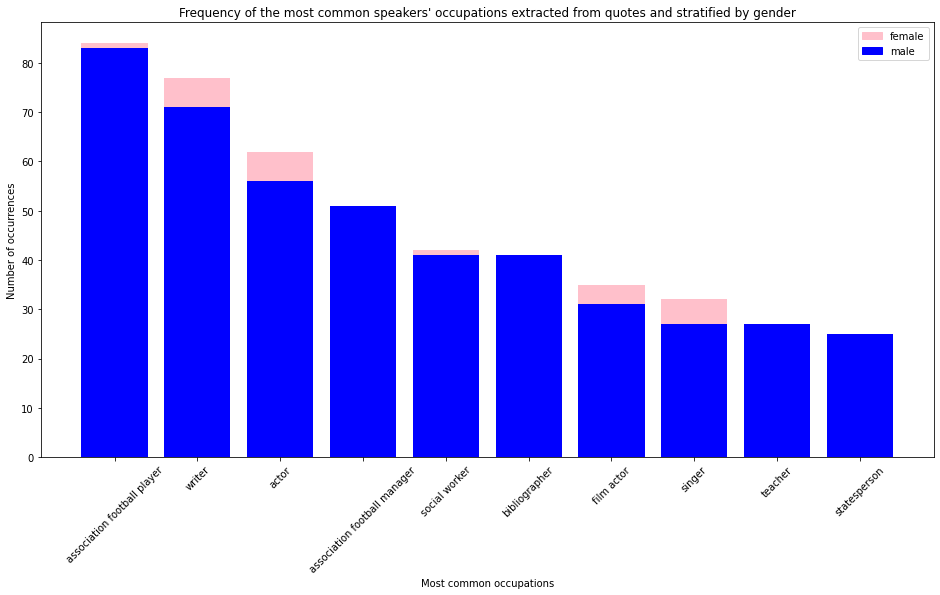

In [ ]:
viewbar('occupations')

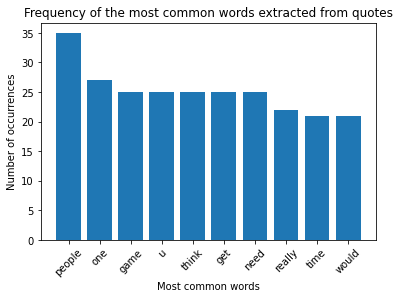

In [ ]:
plt.bar(*zip(*agg_2020['words_frequency'].most_common(10)))
plt.xlabel("Most common words")
plt.ylabel("Number of occurrences")
plt.title("Frequency of the most common words extracted from quotes")
plt.xticks(rotation=45)
plt.show()

As we can see from the graph with the frequency of the most common keywords above, those words are not very meaningful and do not give us any insights, and many of them are filler or syntax words.

Therefore, we shift our strategy of looking at the keywords, and instead of viewing them through the absolute values of occurences, we want to inspect new trends occuring in the dataset.

For that, we look at the relative change of the keywords over the years. We are interested in two kinds of trends

1. New words words that were not present the year before
2. Words with a relatively big spike of occurences

Doing this naively generates noise - a word with a seemingly huge relative change (10 times more popular) could be just used 10 times as opposed to once the last year. Do deal with this noise, we set a treshold of minimal number of occurences to consider a word.

In [ ]:
RELEVANCE_THRESHOLD = 100

def get_interval(y1, y2):
  '''Creates interval between two years.'''

  return f"{y1}-{y2}"

def unfold_interval(i):
  return list(map(int, i.split('-')))


def relative_change_in_time(years_agg, years):
  '''Calculates the relative change of keywords over time.'''

  first_year = years[0]
  relative_change = defaultdict(lambda : {}) 
  
  # stocks dictionaries for each year
  dictionaries = {year: years_agg[year]['words_frequency'] for year in years}

  # if the word was present in the previous dictionary already and its count was bigger 
  # than a threshold, then we add the relative count between the two years
  for year, frequencies in dictionaries.items():
      if year == first_year:
        continue
      for word, count in frequencies.items():
          previous_count = dictionaries.get(year-1, {}).get(word, 0)
          key = get_interval(year-1, year)
          if count < RELEVANCE_THRESHOLD and previous_count != 0:
            relative_change[key][word] = -1
          elif previous_count != 0:
            relative_change[key][word] = count / previous_count
          else:
            relative_change[key][word] = None
  return relative_change


def highest_spikes(relative_change, interval, count=1):
  '''Finds the biggest relative changes.'''

  changes = filter(lambda x: x[1] is not None, relative_change[interval].items())
  return sorted(changes, key=lambda x: x[1], reverse=True)[:count]


def new_trending_words(years_agg, relative_change, interval, count):
  '''Finds the new appearing words.'''

  new_year = unfold_interval(interval)[1]
  get_freq = lambda word: years_agg[new_year]['words_frequency'][word]

  return Counter({
      word: get_freq(word)
      for word, change in relative_change[interval].items()
      if change is None
  }).most_common(count)

In [ ]:
# Let's show how it works with a little demo

years = [2018, 2019]
years_agg = run_chunks_across_years(years, chunk_size=200_000, num_of_chunks=10)

In [ ]:
r_t = relative_change_in_time(years_agg, years)

In [ ]:
highest_spikes(r_t, get_interval(years[0], years[1]), 30)

[('kashmir', 3.6666666666666665),
 ('terrorism', 3.1153846153846154),
 ('hai', 2.6315789473684212),
 ('modi', 2.5689655172413794),
 ('opposition', 2.278688524590164),
 ('strike', 2.22),
 ('majority', 2.0350877192982457),
 ('2019', 2.0153846153846153),
 ('ireland', 1.9821428571428572),
 ('pakistan', 1.8888888888888888),
 ('election', 1.8315217391304348),
 ('leadership', 1.7820512820512822),
 ('terror', 1.7666666666666666),
 ('parliament', 1.7530864197530864),
 ('india', 1.7248576850094877),
 ('campaign', 1.72),
 ('oh', 1.71875),
 ('crore', 1.6565656565656566),
 ('pm', 1.65),
 ('brexit', 1.6435643564356435),
 ('bjp', 1.6407766990291262),
 ('force', 1.6216216216216217),
 ('vote', 1.556390977443609),
 ('crisis', 1.5522388059701493),
 ('brilliant', 1.5454545454545454),
 ('nation', 1.5420560747663552),
 ('character', 1.5420560747663552),
 ('china', 1.5394736842105263),
 ('street', 1.5384615384615385),
 ('brother', 1.5263157894736843)]

In [ ]:
new_trending_words(years_agg, r_t, get_interval(years[0], years[1]), 20)

[('didi', 89),
 ('pulwama', 32),
 ('mamata', 22),
 ('balakot', 21),
 ('banerjee', 19),
 ('dynasty', 15),
 ('goon', 15),
 ('1984', 14),
 ('ha', 13),
 ('broadcast', 12),
 ('lohia', 12),
 ('1947', 11),
 ('margaret', 11),
 ('contesting', 11),
 ('asat', 11),
 ('snclavalin', 11),
 ('chandrayaan', 11),
 ('intolerance', 10),
 ('vande', 10),
 ('advani', 10)]

Finally, we want to observe the relative representation of women in the most common occupations among the most frequent countries.

In [ ]:
# Finding the 10 most recurring countries and occupations in the speaker_attrs dataset
from collections import Counter

#Define a simpler dataframe with only the colums that interests us
speaker_attrs_simp = pd.DataFrame(speaker_attrs, columns = Q_CODES_COLUMNS)

discard_na(speaker_attrs_simp,'nationality')
discard_na(speaker_attrs_simp,'occupation')

all_countries = Counter(list(speaker_attrs_simp.nationality.explode()))
all_occupations = Counter(list(speaker_attrs_simp.occupation.explode()))


most_common_countries = all_countries.most_common(10)
most_common_occupations = all_occupations.most_common(10)
top_common_countries = [a_tuple[0] for a_tuple in most_common_countries]
top_common_occupations = [a_tuple[0] for a_tuple in most_common_occupations]

speaker_attrs_simp = speaker_attrs_simp.explode('nationality')
speaker_attrs_simp = speaker_attrs_simp.explode('occupation')
speaker_attrs_simp = speaker_attrs_simp.explode('gender')

In [ ]:
# Restricting the dataframe to work only with the most common countries, occupations and genders

countries = speaker_attrs_simp[speaker_attrs_simp['nationality'].isin(top_common_countries)]
countries = countries[countries['occupation'].isin(top_common_occupations)]
countries = countries[countries['gender'].isin(['female','male'])]

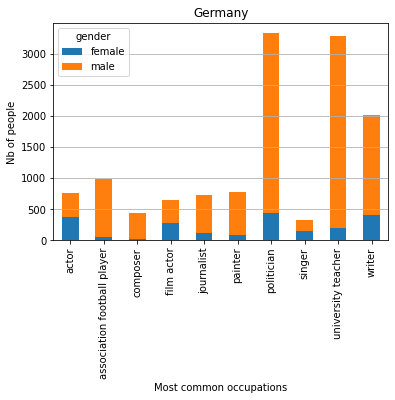

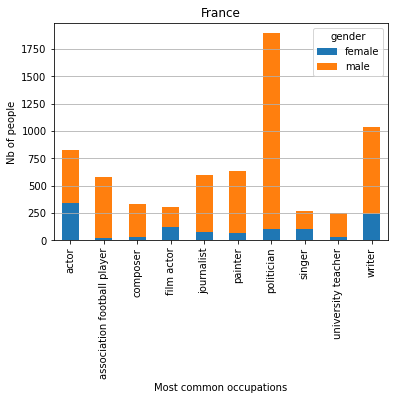

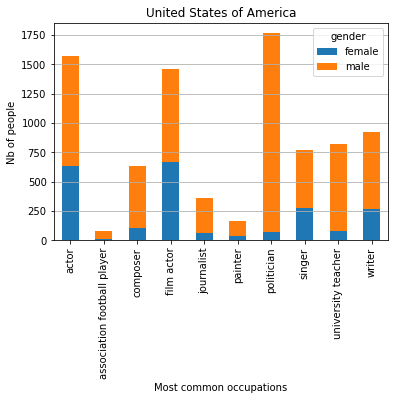

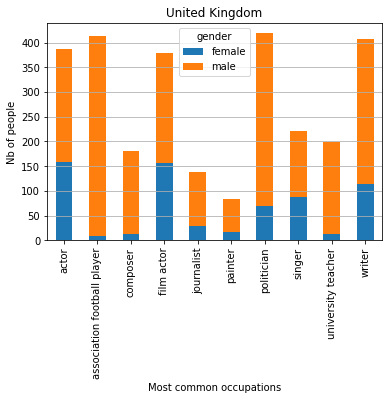

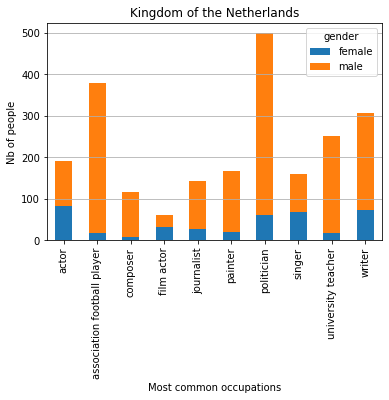

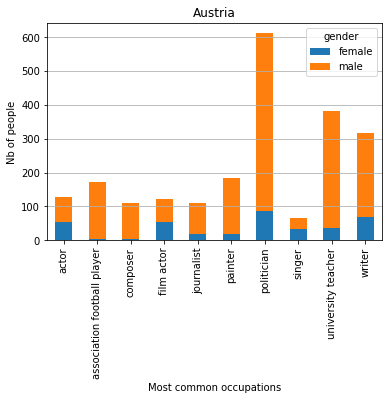

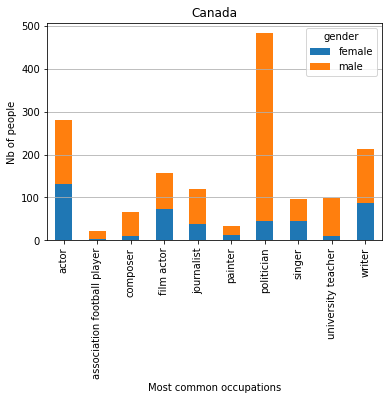

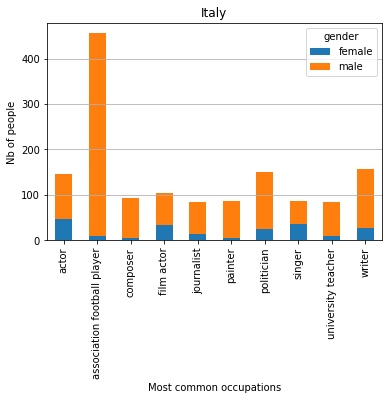

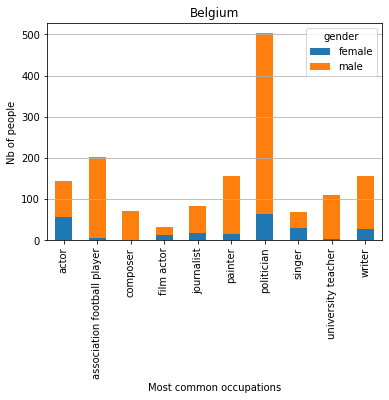

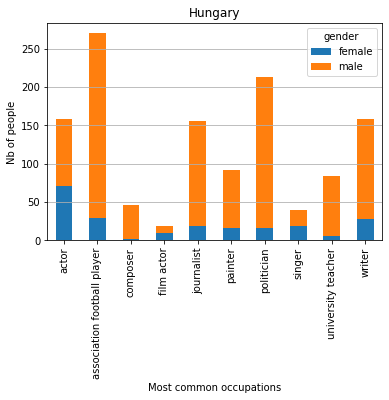

In [ ]:
# Plot of the distribution of the 10 most common occupations stratified by gender for each of the 10 most common countries

for i in range(len(list(countries['nationality'].value_counts()))):
  subset = countries[countries['nationality'] == top_common_countries[i]]
  ax = pd.crosstab(subset['occupation'],subset['gender']).plot(kind='bar', stacked=True)
  ax.yaxis.grid(True)
  ax.set_title(f'{top_common_countries[i]}')
  ax.set_xlabel('Most common occupations')
  ax.set_ylabel('Nb of people')